# Implementação de Máquinas de Vetores Suporte em Julia

   Este capítulo é dedicado a alguns experimentos númericos cujo objetivo é visualizar na prática a implementação da técnica das Máquinas de Vetores de Suporte (SVM), possibilitando assim analisar as particularidades da sua implementação juntamente com referencial teórico matemático desenvolvido no capítulo anterior. 
   
   Para desenvolvimento desses experimentos utilizaremos o *software* de programação Julia em sua versão 1.4.0, além dos pacotes ``Plots`` para gerar as imagens, ``JuMP`` e ``Ipopt`` para resolução dos problemas de otimização, ``RDatasets`` para ter acesso ao conjunto de dados Iris e o pacote ``DataFrame`` para gerar algumas tabelas de dados.
   
   Como abordado anteriormente, Máquinas de Vetores de Suporte é um algoritmo de Aprendizagem de Máquina muito utilizado para classificação e regressão, e nosso objetivo será sua aplicação em problemas que envolvam a classificação de dados. Primeiramente vamos relembrar que em problemas de classificação estamos interessados, assim como o nome já antecipa, em classificar da melhor maneira possível um determinado conjunto de dados. No caso em que os dados são linearmente separáveis, isto é, existe um hiperplano que os separa corretamente, aplica-se a SVM de margem rígida e o problema costuma ter uma resolução mais simples. Entretanto, os problemas de classificação que envolvem situações reais costumam ser mais elaborados, pois neste caso os dados geralmente não são linearmente separáveis. Nestas situações é necessário utilizar a SVM com margem flexível (C-SVM), se os dados forem, a grosso modo, mais "comportados", ou a SVM não-linear. Este último caso exige um desenvolvimento teórico matemático mais avançado e que foge do escopo deste trabalho e portanto não será abordado, se constituindo numa proposta de estudos a ser desenvolvido em projetos futuros. 

In [1]:
using RDatasets, JuMP, Ipopt, Random, LinearAlgebra, Plots, StatsBase, DataFrames, CSV, StatsPlots

## Implementação de SVM para Classificação do Conjunto de Dados Iris

   Neste primeiro momento nosso propósito será implementar o algoritmo de SVM num exemplo prático: o conjunto de dados flor Íris. Tal conjunto de dados consiste em 150 amostras de três espécies da planta Iris, sendo 50 amostras da Iris setosa, 50 da Iris virginica e 50 da Iris versicolor. Cada dado amostral contém as medidas de quatro variáveis morfológicas: comprimento e largura das sépalas e das pétalas, medidas em centímetros. É com base nas diferenciações e semelhanças dessas características que é possível distinguir uma espécie da outra. Tais dados foram introduzidos pelo estatístico e biólogo Ronald Fisher em um artigo seu de 1936, e *"através da combinação dessas quatro características ele desenvolveu um modelo discriminante linear para distinguir as espécies".* (informação retirada da wikipedia, fazer citação correta).

   O conjunto de dados Iris é um exemplo clássico utilizado para testes e estudo de técnicas de classificação em Aprendizagem de Máquina, como por exemplo as Máquinas de Vetores de Suporte. Além disso, este conjunto se constitui num bom exemplo para diferenciar técnicas supervisionadas de não-supervisionadas. Por exemplo, para implementar a técnica de SVM na classificação dos dados Iris será fundamental a informação da espécie a qual cada dado de treinamento pertence, de modo que a máquina consiga aprender detectando um padrão entre as características de cada amostra e a espécie a qual ela pertence de fato. Dessa forma o algoritmo irá criar uma função de decisão que permitirá classificar corretamente novos dados. Ou seja, sem a informação da espécie nos dados de treinamento não é possível aplicar tal técnica, e tal informação é coletada por um indivíduo, isto é, há uma supervisão humana. Enquanto que em técnicas não-supervisionadas os dados não estão previamente rotulados.
   
   Primeiramente, é preciso importar o conjunto de dados Iris. Perceba que as amostras pertencem a três diferentes espécies: Iris setosa, Iris versicolor e Iris virginica. Nosso objetivo inicial será aprender a separar a espécie setosa das demais.

In [38]:
iris = dataset("datasets", "iris")
levels(iris[!,:Species])
iris

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


### Classificação com duas características
   
   É importante lembrar que na modelagem do problema cada dado é representado por um ponto no espaço n-dimensional, em que n é o número de variáveis (características) do problema em questão. inicialmente pretendemos modelar o problema que compreende apenas duas características, assim os dados de entrada $x^{i} \in \mathbb{R}^{2}$. Logo, podemos representar o conjunto de dados através de uma matriz $X_{150\times 2}$, em que cada linha corresponde a um vetor $x^{i}$ e cada coluna às suas características, que neste caso serão comprimento e largura das sépalas, medidas em centímetros. 
   
   Por conseguinte, a obtenção do classificador através da SVM é feita com base num conjunto de dados para os quais há o prévio conhecimento da classe a qual cada amostra $i$ investigada pertence, ou seja, $y_{i} \in \{ -1,1 \}$. Dessa forma, o vetor $Y$ contém a correta classificação de cada dado em relação a sua espécie, a qual é representada numericamente. Logo, amostras da espécie setosa serão classificadas como $1$, enquanto que amostras das espécies versicolor ou virginica serão classificadas em $-1$.

In [39]:
X = convert(Array,iris[:, 1:2]) 
p, n = size(X)

(150, 2)

   Na tabela a seguir é possível visulizar o conjunto de dados com mais clareza, tendo as características de cada amostra e sua respectiva classificação especificadas.

In [40]:
iris_df = DataFrame(X);
iris_df.Y = [species == "setosa" ? 1.0 : -1.0 for species in iris[!,:Species]];
iris_df.Especie = iris.Species
rename!(iris_df, Dict(:x1 => :Comprimento_sepala))
rename!(iris_df, Dict(:x2 => :Largura_sepala))

,Comprimento_sepala,Largura_sepala,Y,Especie
,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.0,setosa
2,4.9,3.0,1.0,setosa
3,4.7,3.2,1.0,setosa
4,4.6,3.1,1.0,setosa
5,5.0,3.6,1.0,setosa
6,5.4,3.9,1.0,setosa
7,4.6,3.4,1.0,setosa
8,5.0,3.4,1.0,setosa
9,4.4,2.9,1.0,setosa


Nosso objetivo será classificar o conjunto de dados acima em setosa e não setosa. Tal classificação será feita com base nas características "comprimento de sépala" e "largura de sépala". Mas antes de formular o problema matematicamente, vamos analisar o gráfico que representa tais dados em relação às duas características citadas. 

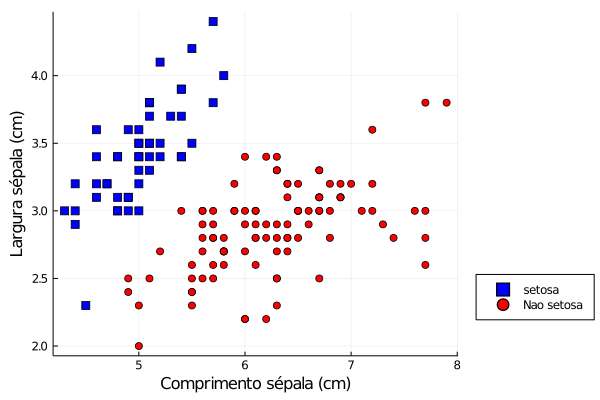

In [41]:
I = findall(iris_df.Y .== 1)
scatter(X[I,1], X[I,2], c=:blue, m=:square, label = "setosa")
I = findall(iris_df.Y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle, label = "Nao setosa", legend=:outerbottomright)
plot!(xlabel="Comprimento sépala (cm)", ylabel="Largura sépala (cm)")

   No gráfico acima estão representados os 150 pontos que correpondem aos nossos dados amostrais, em que os pontos em azul representam a espécie setosa, isto é, os vetores $x^{i}$ tais que $y_{i} = 1$, e os pontos em vermelho as espécies versicolor e virginica que correspondem aos vetores $x^{i}$ tais que $y_{i} = -1$. 

   Como abordado no capítulo anterior, a modelagem do problema de classificação utilizando a técnica de SVM consiste em determinar o hiperplano que melhor separa os dados, classificando-os assim em duas classes. Desse modo, analisando atentamente o gráfico acima pode-se intuir que é possível separar os dados através de um hiperplano, que neste caso será uma reta, pois os dados pertencem ao $\mathbb{R}^{2}$. 

   Ademais, como já demonstrado (citar seção), o hiperplano ótimo é aquele que maximiza a margem que não contenha nenhum dado. Logo, desejamos que os pontos $x^{i}$ satisfaçam a seguinte restrição

$$
y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 50,
$$

e portanto, o problema de encontrar o hiperplano ótimo $\mathcal{H}(w,b)$ é formulado da seguinte forma

\begin{aligned}
\min_{w,b} & \quad \dfrac{1}{2} \Vert w\Vert^{2} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 50, 
\end{aligned}

em que, neste exemplo, $w \in \mathbb{R}^{2}$ e $b\in \mathbb{R}$. 

In [42]:
Random.seed!(0)
trainsize = 50 # Esta é a quantidade de dados que irá compor o conjunto de treinamento.
train_set = sample(1:p,trainsize,replace=false,ordered=true) # Lembre, p=150 é o número total de dados amostrais. Neste comando estamos pedindo para selecionar 30 dados aleatoriamente, e "replace" é para selecionar números diferentes.
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = iris_df.Y[train_set]
Xtest = X[test_set,:]
Ytest = iris_df.Y[test_set]
ptrain = length(Ytrain)
iris_df.conjunto = fill("treino", p)
iris_df.conjunto[test_set] .= "teste"
iris_df

,Comprimento_sepala,Largura_sepala,Y,Especie,conjunto
,Float64,Float64,Float64,Cat…,String
1,5.1,3.5,1.0,setosa,treino
2,4.9,3.0,1.0,setosa,treino
3,4.7,3.2,1.0,setosa,teste
4,4.6,3.1,1.0,setosa,teste
5,5.0,3.6,1.0,setosa,teste
6,5.4,3.9,1.0,setosa,teste
7,4.6,3.4,1.0,setosa,treino
8,5.0,3.4,1.0,setosa,teste
9,4.4,2.9,1.0,setosa,teste


Observe que os 150 dados foram divididos em dois subconjuntos, o conjunto de treinamento, com 50 dados, e o conjunto de teste, com os 100 dados restantes. É através do conjunto de treinamento que o algoritmo de SVM irá "aprender" a classificar os dados detectando padrões entre suas características e a espécie a qual pertencem. Já o conjunto de teste será utilizado para verificar se o classificador encontrado, isto é, o hiperplano ótimo, é bom, averiguando se os dados de teste são classificados corretamente, uma vez que suas saídas já são conhecidas.

A seguir, utilizando o modelo matemático formulado no capítulo anterior, vamos resolver o problema de classificação. 

In [48]:
function SVM_rigida(n, ptrain, Xtrain, Ytrain)
    model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

    @variable(model, w[1:n]) # Aqui declaramos as variáveis.
    @variable(model, b)

    @objective(model, Min, dot(w, w) / 2) # Esta é a função objetivo.

    @constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b) ≥ 1) # Esta é a restrição.

    # print(model) 
    optimize!(model)

    w, b = value.(w), value.(b) # Com este comando queremos que os valores ótimos sejam apresentados.
    return w, b
end
w, b = SVM_rigida(n, ptrain, Xtrain, Ytrain)

([-2.857142829807275, 3.333333301181975], 4.99999995276859)

   Assim, resolvendo o problema (citar) encontramos os valores ótimos para $w$ e $b$, que então representados acima respectivamente, e que definem o hiperplano ótimo. Para melhor visualizar a classificação dos dados de treinamento vamos representá-los graficamente a seguir junto ao hiperplano ótimo.

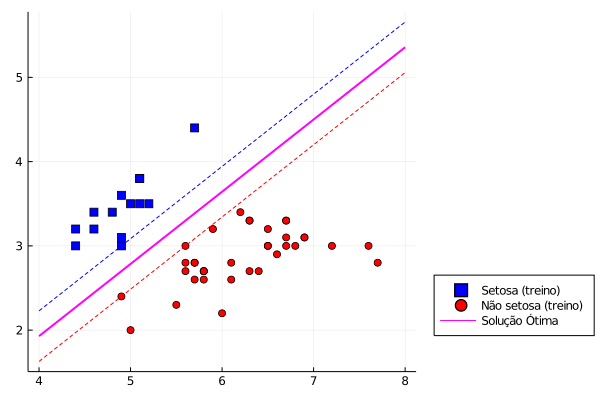

In [44]:
I = findall(Ytrain .== 1)
scatter(Xtrain[I,1], Xtrain[I,2], c=:blue, m=:square, label = "Setosa (treino)", legend=:outerbottomright)
I = findall(Ytrain .== -1)
scatter!(Xtrain[I,1], Xtrain[I,2], c=:red, m=:circle, label = "Não setosa (treino)")
# plot!(leg=false)
plot!(x -> -(w[1] * x + b) / w[2], 4, 8, c=:magenta, lw=:2,label = "Solução Ótima")
plot!(x -> -(w[1] * x + b - 1) / w[2], 4, 8, c=:blue, l=:dash,label = "")
plot!(x -> -(w[1] * x + b + 1) / w[2], 4, 8, c=:red, l=:dash,label = "")

Portanto, no gráfico acima a reta magenta corresponde ao hiperplano ótimo e as retas tracejadas são os hiperplanos que delimitam a máxima margem possível. Observe que o conjuto de dados de treinamento é linearmente separável, pois o hiperplano ótimo os está separando corretamente. 

Alé disso, note que os vetores que estão sobre os hiperplanos da margem são os que se encontram no estado mais crítico e devido a isso são eles que de fato definem o hiperplano separador. Em outras palavras, tais vetores dão suporte ao hiperplano ótimo, de modo que todos os demais vetores poderiam ser descartados sem causar alteração. E temos assim de onde deriva o nome dessa técnica de aprendizagem de máquina supervisionada, Máquinas de Vetores de Suporte.

Por conseguinte, para analisar se o classificador encontrado é realmente bom é necessário verificar se ele também saberá classificar os dados do conjunto de teste corretamente.

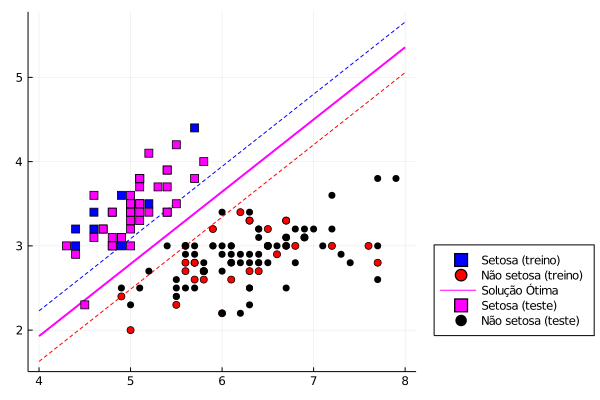

In [45]:
I = findall(Ytest .== 1)
scatter!(Xtest[I,1], Xtest[I,2], c=:magenta, m=:square, label = "Setosa (teste)", legend=:outerbottomright)
I = findall(Ytest .== -1)
scatter!(Xtest[I,1], Xtest[I,2], c=:black, m=:circle, label = "Não setosa (teste)")

Analisando o gráfico acima percebe-se que há um ponto da espécie setosa do conjunto de teste que está localizado ligeiramente do lado direito do hiperplano ótimo, fazendo com que seja classificado incorretamente como não setosa. Assim, como determinar se o classificador encontrado é o melhor?

Para responder a esta pergunta é preciso medir a eficácia do modelo, comparando a real saída dos dados de teste com a respectiva classificação obtida pelo modelo. De modo geral, quanto mais classificações corretas o classificador predizer para o conjunto de teste, mais eficiente ele é. 

Para analisarmos o desempenho do classificador utilizaremos a Matriz de Confusão, também denominada Matriz de Erro, que consiste em uma medida de desempenho muito utilizada para fazer avaliações de modelos de classificação da aprendizagem de máquina supervisionada, como a SVM por exemplo. Ela é uma tabela que apresenta quatro combinações entre a classificação real e a prevista, o que nos permite analisar e visualizar se a previsão sugerida pelo classificador encontrado ao implementar a SVM é condizente com a verdadeira classificação dos dados. Em síntese, a matriz de confusão apresenta as seguintes frequências: Verdadeiro Positivo (VP), Verdadeiro Negativo (VN), Falso Positivo (FP) E Falso Negativo (FN).

Vamos compreender estas terminologias com base na classificação dos dados Iris. Então, para o problema em que desejamos classificar amostras em setosa ($y_{i} = 1$) e não setosa ($y_{i} = -1$), temos que
- Verdadeiro Positivo (VP): quantidade de dados que são setosa ($y_{i} = 1$) e foram classificados como tal ($y_{i} = 1$);
- Verdadeiro Negativo (VN): se refere ao número de dados que não são setosa ($y_{i} = -1$) e foram classificados corretamente como não setosa ($y_{i} = -1$);
- Falso Positivo (FP): quantidade de dados não setosa ($y_{i} = -1$) classificados como setosa ($y_{i} = 1$);
- Falso Negativo (FN): quantidade de dados setosa ($y_{i} = 1$) que receberam classificação não setosa ($y_{i} = -1$).

Assim, a matriz de confusão permite observar a relação entre resultados falsos/verdadeiros e negativos($y_{i} = -1$)/positivos($y_{i} = 1$), fornecendo na diagonal principal o número de acertos da classificação predita em relação a real classificação (VP e VN), enquanto os demais elementos correspondem aos erros na classificação (FP e FN). Vale observar que um classificador ideal apresentaria uma matriz de confusão com os elementos não pertencetes a diagonal principal iguais a zero, pois isso significaria que tal classificador não comete erros. 

Ademais, usando os valores fornecidos pela matriz de confusão podemos calcular a acurácia do modelo, a qual fornece a porcentagem de dados positivos e negativos classificados corretamente. Ela é dada pela seguinte fórmula

$$
\text{Acurácia} = \dfrac{\text{VP} + \text{VN}}{\text{VP} + \text{FP} + \text{VN} + \text{FN}} .
$$

Note que, quanto mais próxima de 1 for a acurácia, mais assertivo é o classificador.

Portanto, para avaliarmos o classificador encontrado, vamos determinar a matriz de confusão para este caso e calcular sua acurácia.

In [86]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)

gdf = filter(:conjunto => x -> x == "teste", iris_df) #filter é uma função. Neste caso, ela foi utilizada para "filtrar"/selecionar em um dataframe que denominamos por "gdf" todos os dados x que possuiam "teste" na coluna "conjunto". Assim, conseguimos analisar a predição do conjunto de teste
gdf.Ypredito = fill(1., p - ptrain) #fill é uma função. Neste caso ela preencheu a coluna Ypredito com 1.
gdf[Nonsetosa, :Ypredito] .= -1

function MatrizConfusao(gdf)
    Verdadeiro_positivo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == 1. && y == 1., gdf)) #nrow nos dá a quantidade de linhas em que ocorre a situação explicitada.
    Verdadeiro_negativo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == -1. && y == -1., gdf))
    Falso_positivo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == -1. && y == 1., gdf))
    Falso_negativo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == 1. && y == -1., gdf))
    
    VP, VN, FP, FN = Verdadeiro_positivo, Verdadeiro_negativo, Falso_positivo, Falso_negativo
        return matrizconfusao = DataFrame(Classe = ["Real Positiva", "Real Negativa"],
                           Predita_Positiva = [VP , FP],
                           Predita_Negativa = [FN, VN] 
                           ) 
end
MatrizConfusao_Iris = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,35,1
2,Real Negativa,0,64


In [57]:
#Y = [species == "setosa" ? 1.0 : -1.0 for species in iris[!,:Species]];
#function MatrizConfusao(Xtest, w, b, p, ptrain, Y, df = iris_df)
#    classe_possitiva = findall(Xtest*w .+ b .>= 0) #setosa
#    classe_negativa = findall(Xtest*w .+ b .< 0) #nonsetosa
#    
#    gdf = filter(:conjunto => x -> x == "teste", df) #filter é uma função. Neste caso, ela foi utilizada para "filtrar"/selecionar em um dataframe que denominamos por "gdf" todos os dados x que possuiam "teste" na coluna "conjunto". Assim, conseguimos analisar a predição do conjunto de teste
#    gdf.Ypredito = fill(1., p - ptrain) #fill é uma função. Neste caso ela preencheu a coluna Ypredito com 1.
#    gdf[classe_negativa, :Ypredito] .= -1
#    
#    Verdadeiro_positivo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == 1. && y == 1., gdf)) #nrow nos dá a quantidade de linhas em que ocorre a situação explicitada.
#    Verdadeiro_negativo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == -1. && y == -1., gdf))
#    Falso_positivo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == -1. && y == 1., gdf))
#    Falso_negativo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == 1. && y == -1., gdf))
#    
#   VP, VN, FP, FN = Verdadeiro_positivo, Verdadeiro_negativo, Falso_positivo, Falso_negativo
#        return matrizconfusao_df = DataFrame( A = [" ", 1, -1], B = [1, VP , FP], C = [-1, FN, VN]) 
#end
#MatrizConfusao_Iris = MatrizConfusao(Xtest, w, b, p, ptrain, Y, df = iris_df)

MethodError: MethodError: no method matching MatrizConfusao(::Array{Float64,2}, ::Array{Float64,1}, ::Float64, ::Int64, ::Int64, ::Array{Float64,1}; df=150×5 DataFrame
│ Row │ Comprimento_sepala │ Largura_sepala │ Y       │ Especie   │ conjunto │
│     │ Float64            │ Float64        │ Float64 │ Cat…      │ String   │
├─────┼────────────────────┼────────────────┼─────────┼───────────┼──────────┤
│ 1   │ 5.1                │ 3.5            │ 1.0     │ setosa    │ treino   │
│ 2   │ 4.9                │ 3.0            │ 1.0     │ setosa    │ treino   │
│ 3   │ 4.7                │ 3.2            │ 1.0     │ setosa    │ teste    │
│ 4   │ 4.6                │ 3.1            │ 1.0     │ setosa    │ teste    │
│ 5   │ 5.0                │ 3.6            │ 1.0     │ setosa    │ teste    │
│ 6   │ 5.4                │ 3.9            │ 1.0     │ setosa    │ teste    │
│ 7   │ 4.6                │ 3.4            │ 1.0     │ setosa    │ treino   │
│ 8   │ 5.0                │ 3.4            │ 1.0     │ setosa    │ teste    │
│ 9   │ 4.4                │ 2.9            │ 1.0     │ setosa    │ teste    │
│ 10  │ 4.9                │ 3.1            │ 1.0     │ setosa    │ teste    │
⋮
│ 140 │ 6.9                │ 3.1            │ -1.0    │ virginica │ treino   │
│ 141 │ 6.7                │ 3.1            │ -1.0    │ virginica │ treino   │
│ 142 │ 6.9                │ 3.1            │ -1.0    │ virginica │ teste    │
│ 143 │ 5.8                │ 2.7            │ -1.0    │ virginica │ teste    │
│ 144 │ 6.8                │ 3.2            │ -1.0    │ virginica │ teste    │
│ 145 │ 6.7                │ 3.3            │ -1.0    │ virginica │ treino   │
│ 146 │ 6.7                │ 3.0            │ -1.0    │ virginica │ treino   │
│ 147 │ 6.3                │ 2.5            │ -1.0    │ virginica │ teste    │
│ 148 │ 6.5                │ 3.0            │ -1.0    │ virginica │ treino   │
│ 149 │ 6.2                │ 3.4            │ -1.0    │ virginica │ treino   │
│ 150 │ 5.9                │ 3.0            │ -1.0    │ virginica │ teste    │)
Closest candidates are:
  MatrizConfusao(::Any, ::Any, ::Any, ::Any, ::Any, ::Any) at In[57]:2 got unsupported keyword argument "df"
  MatrizConfusao(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, !Matched::Any) at In[57]:2 got unsupported keyword argument "df"
  MatrizConfusao(::Any, ::Any, ::Any, ::Any, ::Any) at In[56]:2 got unsupported keyword argument "df"
  ...

A tabela acima corresponde à matriz de confusão para o hiperplano ótimo encontrado, em que dos 100 dados do conjunto de teste, o número de VP = 35, VN = 64, FN = 1 e FP = 0. Ou seja, um dado da espécie setosa foi classificado incorretamente como pertencente às espécies versicolor ou virginica. Em outras palavras, FN = 1 significa que houve um dado pertencente à espécie setosa, $y_{i} = 1$, que foi classificados como $-1$ pelo hiperplano ótimo. 

É possível visualizar este dado no gráfico apresentado anteriormente e como ele é único, analisamos se tal classificação incorreta se repetia nos casos em que a quantidade de dados do conjunto de treinamento fosse maior, averiguando assim se uma maior quantidade não resultaria numa solução mais eficiente e que classificasse todos os dados de maneira correta. Contudo, o que se observou é que mesmo para um conjunto de treino com 100 dados, por exemplo, ainda ocorria uma classificação incorreta, pois os dados são distribuídos de maneira aleatória entre os conjuntos de treino e teste, de modo que tal controle não seja possível. Ademais, é importante que o conjunto de teste não seja tão pequeno em relação ao conjunto de treino para que não ocorram equívocos ao avaliar se o classificador é bom. 

Em vista disso, e no intuito de obter um classificador mais assertivo, vamos então aplicar a técnica de SVM com margem flexível (CSVM) para classificar esse mesmo conjunto de dados Iris e analisar se dessa forma será possível obter uma classificação correta.
Neste caso, utilizamos a regularização, isto é, promovemos um relaxamento das restrições do problema de otimização (citar eq. problema) na tentativa de conseguir classificar corretamente os dados que não estejam no semiespaço correto. Tal relaxamento é feito acrescentando-se variáveis de folga $\xi_{i} \geq 0$ às restrições. Entretanto, o ideal é que a maior quantidade de dados esteja localizado no semiespaço correto, isto é, que o maior número possível de variáveis de folga seja igual a zero. Em outras palavras, desejamos minimizar também os valores das variáveis de folga. Para tanto, acrescentamos à nossa função objetivo do problema de classificação o somatório das variáveis $\xi_{i} \geq 0$ multiplicado por um parâmetro $C >0$. Tal parâmetro nada mais é do que uma penalização aos valores dos $\xi_{i}$.

Desse modo, de acordo com o desenvolvido no Capítulo 5.3, o problema de classificação com margem flexível tem o seguinte formato

\begin{aligned}
\min_{w,b, \xi} & \quad \dfrac{1}{2} \Vert w\Vert^{2} + C\sum_{i=1}^{p} \xi_{i} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1 - \xi_{i} , \quad i=1, \ldots , p, \\
& \quad \xi_{i} \geq 0 , \ \ \ \qquad \qquad \qquad i=1, \ldots , p. 
\end{aligned}

em que $w \in \mathbb{R}^{2}$, $b\in \mathbb{R}$, $\xi \in \mathbb{R}^{p}$ e $C >0$. 

In [87]:
function SVM_flexivel(n, ptrain, Xtrain, Ytrain, C = 1.0)
    model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

    @variable(model, w[1:n]) # Aqui declaramos as variáveis.
    @variable(model, b)
    @variable(model, ξ[1:ptrain] ≥ 0)

    @objective(model, Min, dot(w, w) / 2 + C * sum(ξ)) # Esta é a função objetivo.

    @constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b)  ≥ 1- ξ[i]) # Esta é a restrição.

    # print(model) 
    optimize!(model)

    w, b, ξ = value.(w), value.(b), value.(ξ) #aqui queremos desenhar os valores ótimos
        return w, b, ξ
end
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 1.0)

([-1.8054054084207, 1.567567554887953], 4.721081137153712, [0.0, 0.4227026903529496, 0.0, 0.0, 0.0, 0.0, 0.18054053543518253, 0.26594593486415474, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

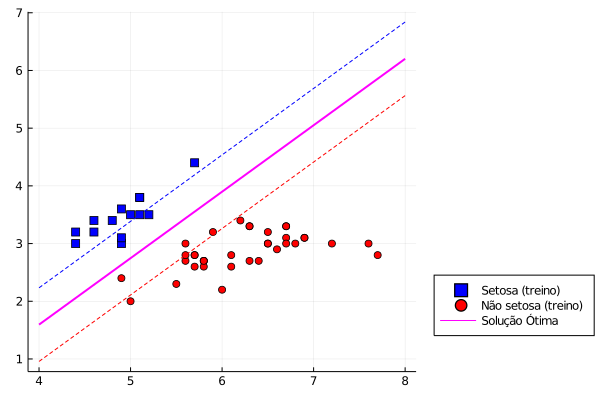

In [88]:
I = findall(ξ .> 1e-6) 
scatter!(Xtrain[I,1], Xtrain[I,2], c=:green, m=(:white, stroke(1,:green), 10))
I = findall(Ytrain .== 1)
scatter(Xtrain[I,1], Xtrain[I,2], c=:blue, m=:square, label = "Setosa (treino)", legend=:outerbottomright)
I = findall(Ytrain .== -1)
scatter!(Xtrain[I,1], Xtrain[I,2], c=:red, m=:circle, label = "Não setosa (treino)")
# plot!(leg=false)
plot!(x -> -(w[1] * x + b) / w[2], 4, 8, c=:magenta, lw=:2,label = "Solução Ótima")
plot!(x -> -(w[1] * x + b - 1) / w[2], 4, 8, c=:blue, l=:dash,label = "")
plot!(x -> -(w[1] * x + b + 1) / w[2], 4, 8, c=:red, l=:dash,label = "")

   Portanto, utilizando regularização e adaptando nosso modelo, obtemos uma nova solução que é apresentada acima. Os valores ótimos encontrados determinam o hiperplano classificador, o qual está representado na cor magenta no gráfico acima, e observe que esta solução é diferente da encontrada anteriormente. De fato, fazendo uma comparação entre este hiperplano ótimo e o determinado no problema em que aplicamos SVM de margem rígida, pode-se perceber que no caso atual os vetores que apresentam $\xi_{i} > 0$ possuem uma maior "liberdade", de modo que possam estar localizados na região entre as margens e o hiperplano separador. Tal "liberdade" é fruto do relaxamento promovido nas restrições através das variáveis de folga, relaxamento que deve ser regulado. É neste contexto que entra o parâmetro $C$. De acordo com Krulikovski (2017), tal parâmetro nos fornece um "equilíbrio entre a maximização da margem e a minimização do erro de classificação". Ou seja,  caso o valor atribuído ao parâmetro de penalização $C$ seja pequeno, uma maior quantidade de vetores recebe folga, inclusive alguns para os quais não seria necessário. Caso contrário, se valores muito altos são atribuídos ao parâmetro $C$, o número de vetores que recebe folga diminui. Contudo, neste último caso o programa tende a se concentrar em minimizar a penalização em vez de maximizar a margem na função objetivo. Em decorrência disso, é de suma importância escolher o valor correto para o parâmetro $C$. Neste exemplo  vamos avaliar a classificação obtida para $C=1$.  

In [89]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", iris_df) #filter é uma função. Neste caso, ela foi utilizada para "filtrar"/selecionar em um dataframe que denominamos por "gdf" todos os dados x que possuiam "teste" na coluna "conjunto". Assim, conseguimos analisar a predição do conjunto de teste
gdf.Ypredito = fill(1., p - ptrain) #fill é uma função. Neste caso ela preencheu a coluna Ypredito com 1.
gdf[Nonsetosa, :Ypredito] .= -1
MatrizConfusao_Iris = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,36,0
2,Real Negativa,0,64


Analisando a matriz de confusão temos que os valores de FN e FP são nulos, o que nos permite concluir que o hiperplano ótimo encontrado atua como um bom classificador, pois todos os dados foram classificados corretamente. De fato, no gráfico a seguir podemos vizualizar que o hiperplano ótimo separa todos os dados dos conjuntos de treino e teste corretamente. 

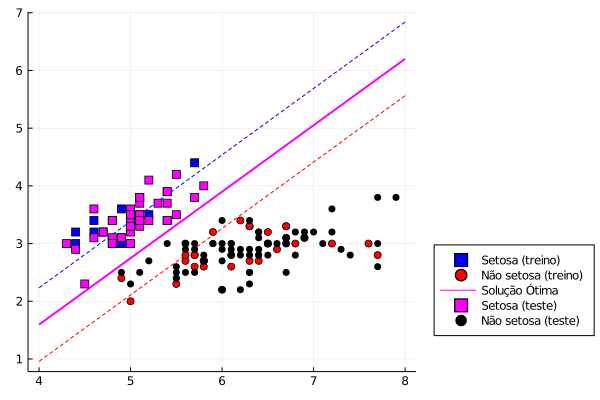

In [90]:
I = findall(Ytest .== 1)
scatter!(Xtest[I,1], Xtest[I,2], c=:magenta, m=:square, label = "Setosa (teste)", legend=:outerbottomright)
I = findall(Ytest .== -1)
scatter!(Xtest[I,1], Xtest[I,2], c=:black, m=:circle, label = "Não setosa (teste)")

Portanto, utilizando a técnica CSVM, com $C = 1$, foi possível determinar um hiperplano separador (classificador) com uma acurácia de 100% para o conjunto de teste.

### Classificação com quatro características
Agora, vamos analisar a implementação da técnica SVM com margem rígida para a classificação do conjunto de dados Iris levando em consideração quatro características. 

In [91]:
X = convert(Array,iris[:, 1:4]) 
p, n = size(X)

(150, 4)

In [92]:
iris_df = DataFrame(X);
iris_df.Y = [species == "setosa" ? 1.0 : -1.0 for species in iris[!,:Species]];
iris_df.Especie = iris.Species
rename!(iris_df, Dict(:x1 => :Comp_sepala))
rename!(iris_df, Dict(:x2 => :Larg_sepala))
rename!(iris_df, Dict(:x3 => :Comp_petala))
rename!(iris_df, Dict(:x4 => :Larg_petala))

,Comp_sepala,Larg_sepala,Comp_petala,Larg_petala,Y,Especie
,Float64,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,1.0,setosa
2,4.9,3.0,1.4,0.2,1.0,setosa
3,4.7,3.2,1.3,0.2,1.0,setosa
4,4.6,3.1,1.5,0.2,1.0,setosa
5,5.0,3.6,1.4,0.2,1.0,setosa
6,5.4,3.9,1.7,0.4,1.0,setosa
7,4.6,3.4,1.4,0.3,1.0,setosa
8,5.0,3.4,1.5,0.2,1.0,setosa
9,4.4,2.9,1.4,0.2,1.0,setosa


Na tabela acima, a primeira coluna apresenta uma enumeração dos dados, as quatro colunas que vêm em seguida correspondem as diferentes características de cada dado amostral, e a última corresponde a espécie correta a qual o dado pertence, sendo classificada como 1 se pertencente à espécie setosa e -1 caso contrário, assim como no exemplo anterior. A principal diferença agora é que os dados do conjunto de entrada pertencem ao $\mathbb{R}^{4}$.

Desse modo, para desenvolvermos uma intuição quanto a separabilidade desses dados, vamos analisar alguns gráficos que representam as espécie setosa e não setosa de acordo com duas características de cada vez.

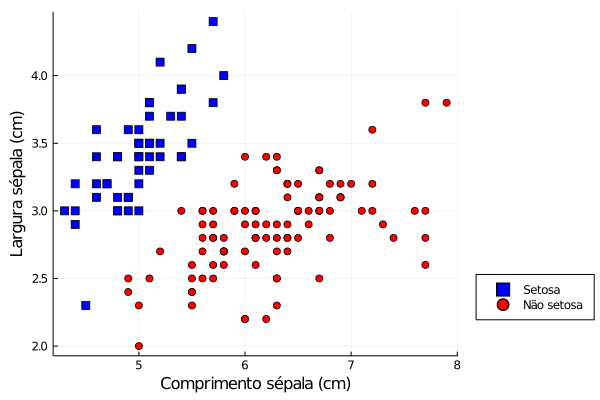

In [93]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,2], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="Comprimento sépala (cm)", ylabel="Largura sépala (cm)")

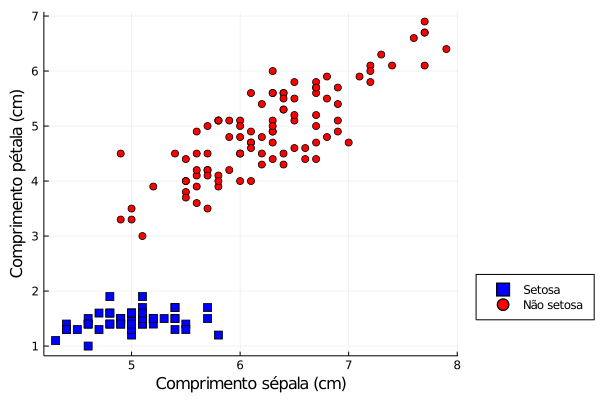

In [94]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,3], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,3], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="Comprimento sépala (cm)", ylabel="Comprimento pétala (cm)")

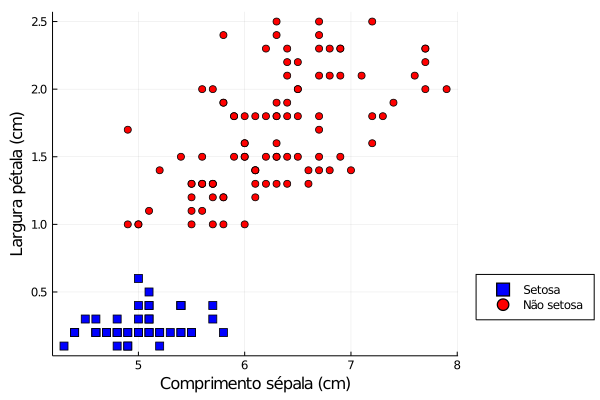

In [95]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,4], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,4], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="Comprimento sépala (cm)", ylabel="Largura pétala (cm)")

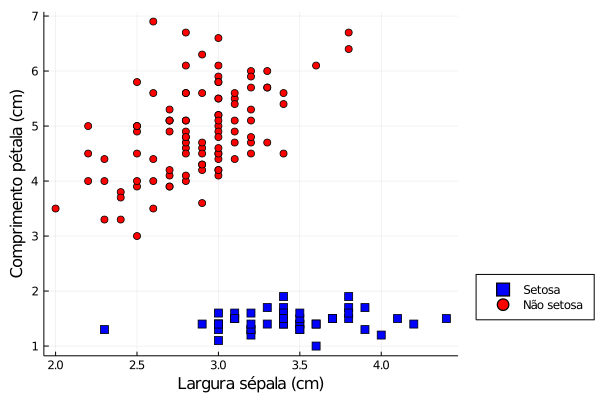

In [96]:
I = findall(Y .== 1)
scatter(X[I,2], X[I,3], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,2], X[I,3], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="Largura sépala (cm)", ylabel="Comprimento pétala (cm)")

Nos gráficos acima temos a representação dos dados amostrais de acordo com suas características, sendo que os dados em azul pertencem à espécie setosa e os dados em vermelho às espécies versicolor e virginica. Analisando tais gráficos percebe-se que em cada um deles os dados aparentam ser linearmente separáveis. Assim, para resolver nosso problema vamos dividir novamente de modo aleatório os dados entre o conjunto de treinamento e o conjunto de teste.

In [97]:
Random.seed!(0)
trainsize = 50 # Esta é a quantidade de dados que irá compor o conjunto de treinamento.
train_set = sample(1:p,trainsize,replace=false,ordered=true) # Lembre, p=150 é o número total de dados amostrais. Neste comando estamos pedindo para selecionar 30 dados aleatoriamente, e "replace" é para selecionar números diferentes.
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = iris_df.Y[train_set]
Xtest = X[test_set,:]
Ytest = iris_df.Y[test_set]
ptrain = length(Ytrain)
iris_df.conjunto = fill("treino", p)
iris_df.conjunto[test_set] .= "teste"
iris_df

,Comp_sepala,Larg_sepala,Comp_petala,Larg_petala,Y,Especie,conjunto
,Float64,Float64,Float64,Float64,Float64,Cat…,String
1,5.1,3.5,1.4,0.2,1.0,setosa,treino
2,4.9,3.0,1.4,0.2,1.0,setosa,treino
3,4.7,3.2,1.3,0.2,1.0,setosa,teste
4,4.6,3.1,1.5,0.2,1.0,setosa,teste
5,5.0,3.6,1.4,0.2,1.0,setosa,teste
6,5.4,3.9,1.7,0.4,1.0,setosa,teste
7,4.6,3.4,1.4,0.3,1.0,setosa,treino
8,5.0,3.4,1.5,0.2,1.0,setosa,teste
9,4.4,2.9,1.4,0.2,1.0,setosa,teste


Tendo definido os conjuntos de treino e teste, vamos agora aplicar a técnica de SVM sobre o conjunto de treino.

In [98]:
w, b = SVM_rigida(n, ptrain, Xtrain, Ytrain)

([-1.9124232393354155e-7, 0.32036626873820034, -0.8237985755072652, -0.3661327030904413], 1.3157898999556978)

Agora, vamos avaliar se o classificador encontrado é bom, isto é, se ele separa os dados corretamente. Para tanto, comparamos a classificação que os dados de teste receberam do hiperplano ótimo com a sua classsificação correta.

In [99]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", iris_df) #filter é uma função. Neste caso, ela foi utilizada para "filtrar"/selecionar em um dataframe que denominamos por "gdf" todos os dados x que possuiam "teste" na coluna "conjunto". Assim, conseguimos analisar a predição do conjunto de teste
gdf.Ypredito = fill(1., p - ptrain) #fill é uma função. Neste caso ela preencheu a coluna Ypredito com 1.
gdf[Nonsetosa, :Ypredito] .= -1
MatrizConfusao_Iris = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,36,0
2,Real Negativa,0,64


Portanto, para o problema que considera as quatro características dos dados amostrais temos que a técnica de SVM de margem rígida nos fornece um hiperplano que atua como um bom classificador, separando corretamente todos os dados, tanto de treinamento quanto de teste.

### Classificação em espécie virginica e não virginica utilizando quatro características

Para finalizar os experimentos numéricos com o conjunto de dados Iris, vamos aprender agora a classificar tal conjunto de dados em virginica e não virginica.
Analisando os gráficos a seguir, em que a espécie virginica está representada na cor verde e as espécies setosa e versicolor na cor amarela, pode-se observar que os dados não são linearmente separáveis. Em vista disso, utilizaremos C-SVM para obter o classificador.

In [100]:
X = convert(Array,iris[:, 1:4]) 
p, n = size(X)

(150, 4)

In [101]:
iris_df = DataFrame(X);
iris_df.Y = [species == "virginica" ? 1.0 : -1.0 for species in iris[!,:Species]];
iris_df.Especie = iris.Species
rename!(iris_df, Dict(:x1 => :Comp_sepala))
rename!(iris_df, Dict(:x2 => :Larg_sepala))
rename!(iris_df, Dict(:x3 => :Comp_petala))
rename!(iris_df, Dict(:x4 => :Larg_petala))

,Comp_sepala,Larg_sepala,Comp_petala,Larg_petala,Y,Especie
,Float64,Float64,Float64,Float64,Float64,Cat…
1,5.1,3.5,1.4,0.2,-1.0,setosa
2,4.9,3.0,1.4,0.2,-1.0,setosa
3,4.7,3.2,1.3,0.2,-1.0,setosa
4,4.6,3.1,1.5,0.2,-1.0,setosa
5,5.0,3.6,1.4,0.2,-1.0,setosa
6,5.4,3.9,1.7,0.4,-1.0,setosa
7,4.6,3.4,1.4,0.3,-1.0,setosa
8,5.0,3.4,1.5,0.2,-1.0,setosa
9,4.4,2.9,1.4,0.2,-1.0,setosa


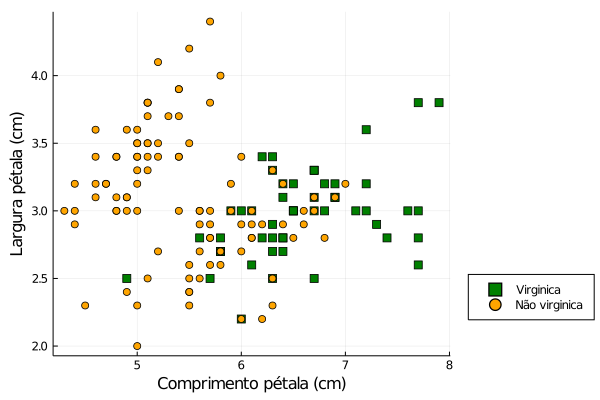

In [102]:
I = findall(iris_df.Y .== 1)
scatter(X[I,1], X[I,2], c=:green, m=:square, label = "Virginica")
I = findall(iris_df.Y .== -1)
scatter!(X[I,1], X[I,2], c=:orange, m=:circle, label = "Não virginica", legend=:outerbottomright)
plot!(xlabel="Comprimento pétala (cm)", ylabel="Largura pétala (cm)")

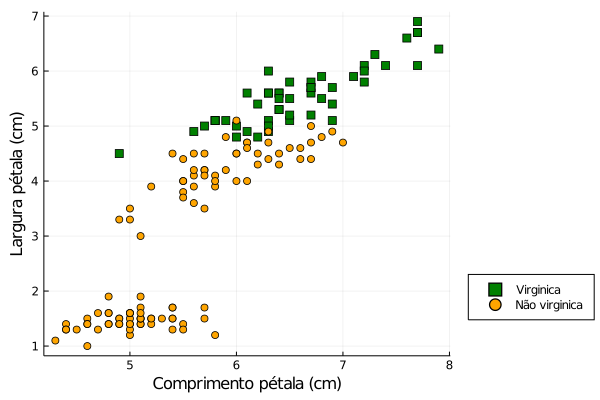

In [103]:
I = findall(iris_df.Y .== 1)
scatter(X[I,1], X[I,3], c=:green, m=:square, label = "Virginica")
I = findall(iris_df.Y .== -1)
scatter!(X[I,1], X[I,3], c=:orange, m=:circle, label = "Não virginica", legend=:outerbottomright)
plot!(xlabel="Comprimento pétala (cm)", ylabel="Largura pétala (cm)")

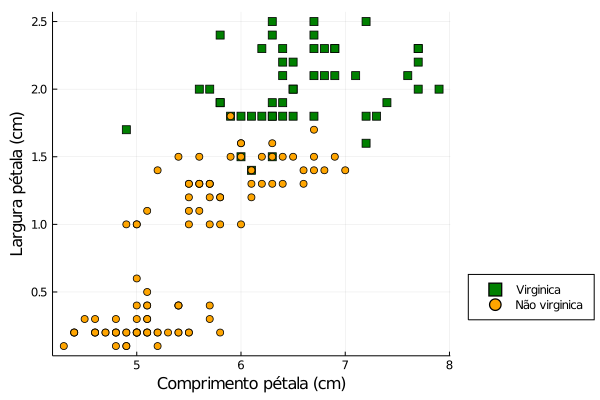

In [104]:
I = findall(iris_df.Y .== 1)
scatter(X[I,1], X[I,4], c=:green, m=:square, label = "Virginica")
I = findall(iris_df.Y .== -1)
scatter!(X[I,1], X[I,4], c=:orange, m=:circle, label = "Não virginica", legend=:outerbottomright)
plot!(xlabel="Comprimento pétala (cm)", ylabel="Largura pétala (cm)")

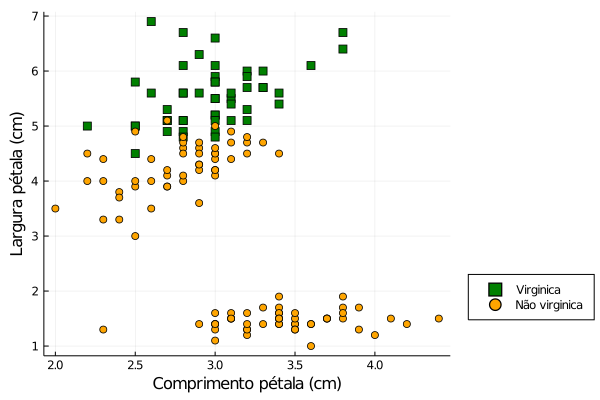

In [105]:
I = findall(iris_df.Y .== 1)
scatter(X[I,2], X[I,3], c=:green, m=:square, label = "Virginica")
I = findall(iris_df.Y.== -1)
scatter!(X[I,2], X[I,3], c=:orange, m=:circle, label = "Não virginica", legend=:outerbottomright)
plot!(xlabel="Comprimento pétala (cm)", ylabel="Largura pétala (cm)")

De modo análogo ao que foi desenvolvido anteriormente, é necessário primeiramente dividir aleatoriamente o conjunto total de dados em dois subconjuntos: conjunto de treinamento e conjunto de testes. Neste caso, o conjunto de treinamento será composto por 75 dados e o conjunto de teste pelos 75 dados restantes.

In [106]:
Random.seed!(0)
trainsize = 75 # Esta é a quantidade de dados que irá compor o conjunto de treinamento.
train_set = sample(1:p,trainsize,replace=false,ordered=true) # Lembre, p=150 é o número total de dados amostrais. Neste comando estamos pedindo para selecionar 30 dados aleatoriamente, e "replace" é para selecionar números diferentes.
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = iris_df.Y[train_set]
Xtest = X[test_set,:]
Ytest = iris_df.Y[test_set]
ptrain = length(Ytrain)
iris_df.conjunto = fill("treino", p)
iris_df.conjunto[test_set] .= "teste"
iris_df

,Comp_sepala,Larg_sepala,Comp_petala,Larg_petala,Y,Especie,conjunto
,Float64,Float64,Float64,Float64,Float64,Cat…,String
1,5.1,3.5,1.4,0.2,-1.0,setosa,treino
2,4.9,3.0,1.4,0.2,-1.0,setosa,treino
3,4.7,3.2,1.3,0.2,-1.0,setosa,teste
4,4.6,3.1,1.5,0.2,-1.0,setosa,teste
5,5.0,3.6,1.4,0.2,-1.0,setosa,treino
6,5.4,3.9,1.7,0.4,-1.0,setosa,teste
7,4.6,3.4,1.4,0.3,-1.0,setosa,teste
8,5.0,3.4,1.5,0.2,-1.0,setosa,treino
9,4.4,2.9,1.4,0.2,-1.0,setosa,teste


Para obter o classificador ótimo aplicamos novamente a função SVM de margem flexível (C-SVM) utilizando o parâmetro $C = 1$. 

In [107]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain)

([-0.34567545524447024, -0.8049690813571304, 1.7254845918550483, 1.6080094600267834], -6.676855229902282, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.8965384097436052, 0.0, 4.7540132568274685e-9, 0.0, 0.0, 0.0, 0.0])

In [108]:
Virginica = findall(Xtest*w .+ b .>= 0)
Nonvirginica = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", iris_df) 
gdf.Ypredito = fill(1., p - ptrain) 
gdf[Nonvirginica, :Ypredito] .= -1
MatrizConfusao_Iris = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,23,0
2,Real Negativa,0,52


Portanto, o classificador encontrado é bom, pois o retorno `true` acima nos afirma que o hiperplano ótimo também classifica corretamente os dados do conjunto de teste.

## Implementação de SVM para Classificação de Dados de Câncer de Mama

   De acordo com o Instituto Nacional de Câncer (INCA), "*Câncer é o nome dado a um conjunto de mais de 100 doenças que têm em comum o crescimento desordenado de células, que invadem tecidos e órgãos. Dividindo-se rapidamente, estas células tendem a ser muito agressivas e incontroláveis, determinando a formação de tumores, que podem espalhar-se para outras regiões do corpo.*" O câncer de mama por sua vez ocorre quando há formação de tumor na mama, sendo o tipo de câncer mais incidente entre as mulheres, tanto no Brasil quanto no mundo. No mundo, somente em 2018, foram registrados cerca de 2,1 milhões de novos casos, número que equivale a 11,6% de todos os cânceres estimados. No Brasil, em 2017, ocorreram 16.724 óbitos por câncer de mama, e segundo estimativas do INCA,  são estimados cerca de 66.280 novos casos de câncer de mama no Brasil para cada ano do triênio 2020-2022, o que correponde a uma taxa de incidência de 61,61 novos casos a cada 100 mil mulheres. 
   O diagnóstico precoce é um dos principais fatores que contribuem para reduzir a mortalidade por câncer, possibilitando cerca de 95% de chances de cura. Neste contexto, "*A mamografia é uma das melhores técnicas para o rastreamento do câncer de mama disponível atualmente, capaz de registrar imagens da mama com a finalidade de diagnosticar a presença ou ausência de estruturas que possam indicar a doença. Com esse tipo de exame pode-se detectar o tumor antes que ele se torne palpável.*" (LEAL, LIMA e SILVA, 2019). 
   Tendo em vista as altas taxas de incidência e mortes causadas pelo câncer de mama, muita pesquisas científicas vem sendo desenvolvidas nos últimos anos com o intuito de auxiliar no diagnósticos de doenças, tornando as técnicas de aprendizagem de máquina cada vez mais presentes na área médica. 
   
   Visto que este tema é de grande relevância e interesse, o próximo experimento numérico tem como objetivo utilizar a técnica de C-SVM para classificar um conjunto de dados sobre células de câncer de mama em tumores malignos e benignos. 
   Este conjunto é composto por 569 dados, em que cada um possui um número de identidade (ID), sua classificação em tumor maligno (M) ou benigno (B) e 30 características de núcleos celulares presentes em imagens digitalizadas de um aspirado por agulha fina (do inglês *fine needle aspirate*, FNA), de uma massa mamária. As características extraídas dos núcleos celulares são:
- Raio (média das distâncias do centro aos pontos do perímetro);
- Textura (desvio padrão dos valores da escala cinza); 
- Perímetro;
- Área;
- Suavidade (variação local nos comprimentos do raio);
- Compactação ($\dfrac{\text{perímetro}^{2}}{área - 1.0}$);
- Concavidade (severidade das porções côncavas do contorno);
- Pontos côncavos (número de partes côncavas do contorno);
- Simetria;
- Dimensão fractal ("aproximação da costa" - 1).

Além disso, para cada imagem foram calculadas a média, o desvido padrão e o "pior" ou maior (média dos três maiores valores) dos valores atribuídos a cada um dos atributos acima mencionados, resultando nas 30 características da tabela a seguir. 

In [124]:
col_headers = ["id" ,"diagnosis" ,"radius_mean" ,"texture_mean" ,"perimeter_mean" ,"area_mean" ,"smoothness_mean" ,"compactness_mean" ,"concavity_mean" ,"concave points_mean" ,"symmetry_mean" ,"fractal_dimension_mean" ,"radius_se" ,"texture_se" ,"perimeter_se" ,"area_se" ,"smoothness_se" ,"compactness_se" ,"concavity_se" ,"concave points_se" ,"symmetry_se" ,"fractal_dimension_se" ,"radius_worst" ,"texture_worst" ,"perimeter_worst" ,"area_worst" ,"smoothness_worst" ,"compactness_worst" ,"concavity_worst" ,"concave points_worst" ,"symmetry_worst" ,"fractal_dimension_worst"]
cancer_df = CSV.read("cancer_data.csv", header = col_headers,)
#cancer_df = DataFrame(dfcancer)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean
,Int64,String,Float64,Float64,Float64,Float64,Float64
1,842302,M,17.99,10.38,122.8,1001.0,0.1184
2,842517,M,20.57,17.77,132.9,1326.0,0.08474
3,84300903,M,19.69,21.25,130.0,1203.0,0.1096
4,84348301,M,11.42,20.38,77.58,386.1,0.1425
5,84358402,M,20.29,14.34,135.1,1297.0,0.1003
6,843786,M,12.45,15.7,82.57,477.1,0.1278
7,844359,M,18.25,19.98,119.6,1040.0,0.09463
8,84458202,M,13.71,20.83,90.2,577.9,0.1189
9,844981,M,13.0,21.82,87.5,519.8,0.1273


In [125]:
X = convert(Array,cancer_df[:, 3:end]) 
p, n = size(X)

(569, 30)

In [126]:
cancer_df.Y = [diagnosis == "M" ? 1.0 : -1.0 for diagnosis in cancer_df[!,:diagnosis]];

Na tabela anterior temos representados os dados, seu diagnóstico e suas características. Neste caso, cada dado $x^{i}$ do conjunto de entrada pertence ao $\mathbb{R}^{30}$, pois são 30 as características. Ademais, assim como é possível observar na definição do vetor $Y$, dados diagnosticados como malignos (M) serão classificados como $1$, e dados com diagnóstico benignos serão classificados em $-1$.  

A seguir, apresentamos alguns gráficos com base em duas características de cada vez para avaliarmos a separabilidade de tal conjunto.

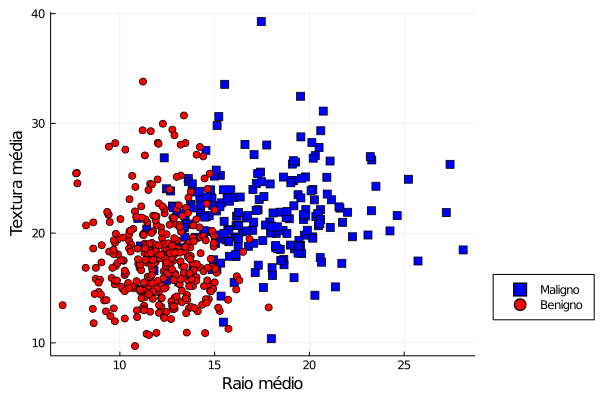

In [112]:
gdf_cancer = groupby(cancer_df,:diagnosis)
@df gdf_cancer[1] scatter(:radius_mean, :texture_mean, c=:blue, m=:square, label = "Maligno")
@df gdf_cancer[2] scatter!(:radius_mean, :texture_mean, c=:red, m=:circle, label = "Benigno", legend=:outerbottomright)
xlabel!("Raio médio")
ylabel!("Textura média")

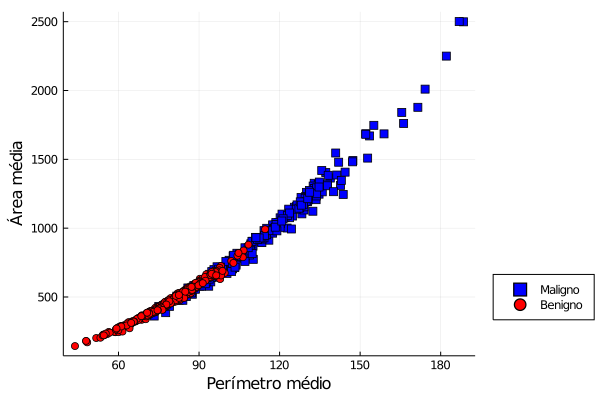

In [113]:
gdf_cancer = groupby(cancer_df,:diagnosis)
@df gdf_cancer[1] scatter(:perimeter_mean, :area_mean, c=:blue, m=:square, label = "Maligno")
@df gdf_cancer[2] scatter!(:perimeter_mean, :area_mean, c=:red, m=:circle, label = "Benigno", legend=:outerbottomright)
xlabel!("Perímetro médio")
ylabel!("Área média")

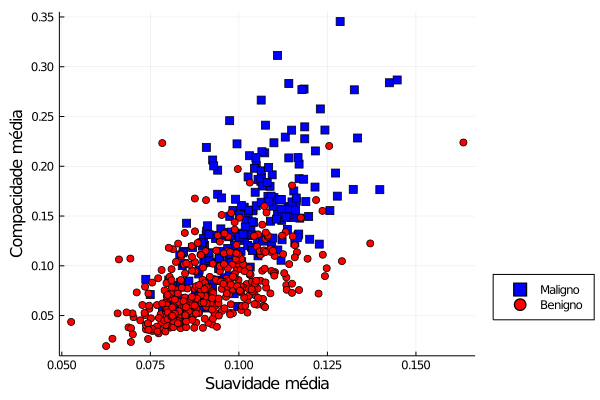

In [114]:
gdf_cancer = groupby(cancer_df,:diagnosis)
@df gdf_cancer[1] scatter(:smoothness_mean,:compactness_mean, c=:blue, m=:square, label = "Maligno")
@df gdf_cancer[2] scatter!(:smoothness_mean,:compactness_mean, c=:red, m=:circle, label = "Benigno", legend=:outerbottomright)
xlabel!("Suavidade média")
ylabel!("Compacidade média")

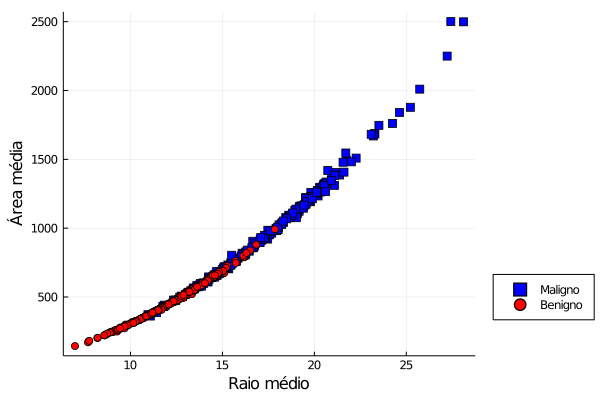

In [115]:
gdf_cancer = groupby(cancer_df,:diagnosis)
@df gdf_cancer[1] scatter(:radius_mean,:area_mean, c=:blue, m=:square, label = "Maligno")
@df gdf_cancer[2] scatter!(:radius_mean,:area_mean, c=:red, m=:circle, label = "Benigno", legend=:outerbottomright)
xlabel!("Raio médio")
ylabel!("Área média")

Com base nos gráficos apresentados acima, em que apenas duas características foram consideradas para a cosntrução de cada gráfico, é possível intuir que os dados não são linearmente separáveis. Em vista disso, vamos aplicar a técnica SVM com margem flexível para classificar os dados deste conjunto em câncer Maligno ou Benigno e então discutir os resultados encontrados.

Utilizando a função `SVM_flexivel` criada com base na modelagem matemática desenvolvida no Capítulo 5.3 para o problema de classificação de dados não linearmente separáveis, vamos determinar os valores ótimos de $w^{*}, b^{*}$ e $\xi^{*}$ para os seguintes valores para o parâmetro $C$:$10^{-3}, 10^{-2}, 10^{-1} , 1, 10, 10^{2}, 10^{3}$.

In [127]:
Random.seed!(0)
trainsize = 150 # Esta é a quantidade de dados que irá compor o conjunto de treinamento.
train_set = sample(1:p,trainsize,replace=false,ordered=true) # Lembre, p=569 é o número total de dados amostrais. Neste comando estamos pedindo para selecionar 300 dados aleatoriamente, e "replace" é para selecionar números diferentes.
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = cancer_df.Y[train_set]
Xtest = X[test_set,:]
Ytest = cancer_df.Y[test_set]
ptrain = length(Ytrain)
cancer_df.conjunto = fill("treino", p)
cancer_df.conjunto[test_set] .= "teste"
cancer_df;

In [128]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e-3)

([-0.008071834546164055, 0.02964516170483992, 0.05439311212608333, -0.011592597530669197, 0.0010117589836746482, 0.003059179554266445, 0.00469094216762709, 0.0018313777890004742, 0.0023394131861448463, 0.0003206848554581697  …  0.0008173819959716312, 0.07826525542595351, 0.09129580035638003, 0.005833410145061603, 0.0020906762524775875, 0.008699190259215589, 0.01033383513687236, 0.00356457271058732, 0.00579540977912883, 0.0009855438257824088], -15.648973824054996, [8.090908928375011e-8, 8.090908690357927e-8, 8.090902577159512e-8, 1.5151717982985544, 8.090908937916708e-8, 8.090908950356853e-8, 8.090908229597614e-8, 1.1277075000492554, 8.090908126371524e-8, 1.2533920792608306e-7  …  8.090908705997125e-8, 8.090908560549803e-8, 8.090894497521895e-8, 8.090908643441776e-8, 8.090908688233132e-8, 8.090906837019454e-8, 8.090908456189375e-8, 8.090908662184402e-8, 8.090895727226532e-8, 0.30469823356286746])

In [130]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
MatrizConfusao_Cancer = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,143,17
2,Real Negativa,6,253


In [131]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e-2)

([-0.08883859935941509, -0.0007301764450351338, 0.11196686858229796, -0.015880476369110896, 0.0077308924966434265, 0.01828321056890381, 0.0318465212114556, 0.012830609393021945, 0.019070023730440845, 0.0014135096052743143  …  -0.02053124086571956, 0.1513050861013803, 0.1628249854452688, 0.0029656267819460325, 0.015498496314976528, 0.05406193808794602, 0.06897533125709296, 0.02420806592934625, 0.05046217998632266, 0.004051358075620132], -23.616685170113474, [1.5059034230248166e-8, 1.505902784015334e-8, 1.5059013504676282e-8, 1.4993461320183339, 1.5059034010093344e-8, 1.5059034338182133e-8, 1.505902765553629e-8, 0.8223470172586017, 1.5059027661030145e-8, 3.245062406322502e-8  …  1.5059030618342077e-8, 1.5059031346579448e-8, 1.505898282181878e-8, 1.505903210903274e-8, 1.505903246813715e-8, 1.5059015417531872e-8, 1.505903027745674e-8, 1.5059032227815374e-8, 1.5057894542135392e-8, 0.3697295777511198])

In [132]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
MatrizConfusao_Cancer = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,144,16
2,Real Negativa,6,253


In [133]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e-1)

([-0.7729017246884566, -0.1406586374058212, 0.32841352824399955, -0.023165676695901805, 0.06467371096380553, 0.14063135523300005, 0.2613983556131847, 0.10085914480945476, 0.15929257739876423, 0.008169698828665002  …  -0.2061791916413598, 0.3305765154420947, 0.18364189309897802, 0.006979634425618434, 0.12293945576818568, 0.44567730493780655, 0.531464519993343, 0.1782847893344932, 0.4722469677605428, 0.030492652655000313], -33.343409789212245, [0.0, 0.0, 0.0, 1.1737976617238983, 0.0, 0.0, 0.0, 0.2866762387701526, 0.0, 7.891659837529961e-9  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [134]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
MatrizConfusao_Cancer = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,151,9
2,Real Negativa,10,249


In [135]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 1.0)

([-0.7729017246884566, -0.1406586374058212, 0.32841352824399955, -0.023165676695901805, 0.06467371096380553, 0.14063135523300005, 0.2613983556131847, 0.10085914480945476, 0.15929257739876423, 0.008169698828665002  …  -0.2061791916413598, 0.3305765154420947, 0.18364189309897802, 0.006979634425618434, 0.12293945576818568, 0.44567730493780655, 0.531464519993343, 0.1782847893344932, 0.4722469677605428, 0.030492652655000313], -33.343409789212245, [0.0, 0.0, 0.0, 1.1737976617238983, 0.0, 0.0, 0.0, 0.2866762387701526, 0.0, 7.891659837529961e-9  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [136]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
MatrizConfusao_Cancer = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,151,9
2,Real Negativa,10,249


In [137]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10)

([-3.6487762436326836, -0.29959521673733175, 0.5274961875892948, 0.001283865955048474, 0.31330786463628163, 0.6543943804337382, 1.0338805180518638, 0.4276064986495521, 0.9735932658298027, -0.006822715279178024  …  -1.5067614807593293, 0.5207062274097332, 0.0813400268574002, 0.018028717775124402, 0.7427837309049162, 1.2626847689039904, 1.7414994379042148, 1.0445809691645298, 2.970881403107341, 0.044847280662490115], -4.738710351251095, [0.0, 0.0, 0.0, 0.6794234691449967, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [138]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
MatrizConfusao_Cancer = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,153,7
2,Real Negativa,9,250


In [139]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e2)

([-11.728964719304864, -0.6531286380075404, 0.7857005039636233, 0.07695537025813765, 2.3008892175891917, 2.263952420402395, 4.165137374759006, 2.301228551624926, 2.2592551232672107, -0.5087724179919326  …  2.7732654840040873, 1.2189973849578957, 0.4555928575164663, -0.05457501150167875, 3.9712797002793803, 1.0295346824208211, -1.036891270048293, 2.6204037204964297, 6.953967977313699, -1.0591624084845783], -20.128105044575477, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [140]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
MatrizConfusao_Cancer = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,149,11
2,Real Negativa,9,250


In [141]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e3)

([-11.728964150295528, -0.6531283956251783, 0.7857003945369919, 0.07695536854528752, 2.30088867859325, 2.2639527719715957, 4.165137969194577, 2.3012284565415655, 2.25925504923999, -0.5087721011621547  …  2.773266565376222, 1.2189972289698123, 0.4555928463105921, -0.05457501831399952, 3.971279019697429, 1.0295369295765158, -1.0368898026407656, 2.620402760011636, 6.953970370774817, -1.0591615387820736], -20.128115472988423, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [142]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
MatrizConfusao_Cancer = MatrizConfusao(gdf)

,Classe,Predita_Positiva,Predita_Negativa
,String,Int64,Int64
1,Real Positiva,149,11
2,Real Negativa,9,250


Para escolher o parâmetro $C$ que nos fornece o melhor classificador é preciso avaliar os resultados obtidos para diferentes valores de $C$. Note que quanto maior o valor de $C$, menor a margem de separação, pois há um maior controle sobre as variáveis de folga. Tanto é que a partir de $C = 10^{2}$ as variáveis de folga $\xi_{i}$ são todas nulas. 

Como neste caso não é possível visualizar graficamente os hiperplanos ótimos encontrados para cada $C$, vamos utilizar a Matriz de Erro, também denominada Matruz de Confusão, em cada caso para avaliá-los.

### Referências
Sites usados para obter estimativas dados de câncer e referenciar:
- https://www.sbmastologia.com.br/noticias/inca-lanca-estimativa-da-incidencia-de-cancer-de-mama-no-brasil/
- https://www.inca.gov.br/tipos-de-cancer/cancer-de-mama
- https://www.femama.org.br/2018/br/noticia/o-cancer-de-mama-em-numeros

aplicação de SVM em dados de câncer de mama:
- https://fei.edu.br/~cet/AlbertXavier_WVC2011.pdf
- https://www.scielo.br/pdf/tema/v20n2/2179-8451-tema-20-02-229.pdf (LEAL, LIMA e SILVA, 2019).

dados câncer de mama disponíveis em:
- https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
Citar como: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. - já acrescentado no bibtext.
- http://pages.cs.wisc.edu/~olvi/uwmp/cancer.html